In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hunter-x-hunter-subtitles/dataset.txt


In [2]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch

2025-09-06 10:59:45.334383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757156385.498038      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757156385.546300      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#Punkt is a pre-trained tokenizer model
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from glob import glob
file = glob('/kaggle/input/hunter-x-hunter-subtitles/dataset.txt')

In [5]:
file

['/kaggle/input/hunter-x-hunter-subtitles/dataset.txt']

# Let's divide the subtitles into episodes.

* We can notice that every episode starts with a title in this format: "Something x Of x Something". Then, there is a narrator’s introduction (if it exists). We will try to split the subtitles every time we find a title and remove the narrator’s introduction if it exists.

In [6]:
import re
from collections import defaultdict

NEXT_TIME_RE = re.compile(r"^\s*Next\s*time:\s*(.+?)\s*\.?\s*$", re.I)
TITLE_RE     = re.compile(r"^[^\S\r\n]*.*\b\w+\b.*\s+x\s+.*\b\w+\b(?:\s+x\s+.*\b\w+\b)?\.?\s*$", re.I)
def _norm(s: str) -> str:
    s = s.strip().lstrip("\ufeff�•-–—►•●·")
    return re.sub(r"\s+", " ", s)

def episode_starts_by_next_time(lines, lookahead=40):
    """
    Returns a sorted list of line indices where each episode starts.
    Logic:
      - assume first episode starts at 0
      - for each 'Next time:' line, jump forward to the next title-like line -> start of next episode
      - tolerate the title being up to `lookahead` lines after 'Next time:'
    """
    L = [_norm(x) for x in lines]  # light normalization (keeps indices)
    n = len(L)

    starts = {0}
    for i, line in enumerate(L):
        if NEXT_TIME_RE.match(line):
            # find the first subsequent title card
            start_idx = None
            for j in range(i + 1, min(i + 1 + lookahead, n)):
                if TITLE_RE.match(L[j]):
                    start_idx = j
                    break
            # fallback: if no title found soon, start at next non-empty line
            if start_idx is None:
                for j in range(i + 1, min(i + 1 + lookahead, n)):
                    if L[j]:
                        start_idx = j
                        break
            if start_idx is not None:
                # avoid duplicates if two pointers land very close
                if not any(abs(start_idx - s) <= 2 for s in starts):
                    starts.add(start_idx)

    return sorted(starts)


In [7]:
with open(file[0], "r", encoding="utf-8") as f:
    raw = [x.rstrip("\n") for x in f.readlines()]

# drop empty lines early and normalize once
raw = [_norm(x) for x in raw if x.strip()]

starts = episode_starts_by_next_time(raw)

In [8]:
len(starts)

145

In [9]:
# HxH title: "Something x Of x Something"
TITLE_RE   = re.compile(r"^\s*.+\s+x\s+.+\s+x\s+.+\s*$", re.I)
PREVIEW_RE = re.compile(r"^\s*next\s*time\s*:\s*.+\s+x\s+.+\s+x\s+.+\s*$", re.I)

def is_preview_line(line: str) -> bool:
    return bool(PREVIEW_RE.match(line))

def clean_episode(chunk, intro_window=12):
    """
    Return (episode_lines, episode_title):
      - intro removed,
      - extract and save episode title ("... x ... x ..."),
      - stop before 'Next time: ... x ... x ...'.
    """
    # 1) detect intro end
    intro_end = None
    for i, ln in enumerate(chunk[:intro_window]):
        if re.search(r"\bas\s+hunters!?\.?$", ln, re.I):
            intro_end = i
            break
    start_idx = (intro_end + 1) if intro_end is not None else 0

    # 2) find preview line to cut the tail
    end_idx = len(chunk)
    for j, ln in enumerate(chunk[start_idx:], start_idx):
        if is_preview_line(ln):
            end_idx = j
            break

    # 3) slice and extract
    ep_lines = []
    ep_title = None
    for ln in chunk[start_idx:end_idx]:
        if TITLE_RE.match(ln):
            ep_title = ln.strip()   # store title
            continue                # skip from lines
        if ln.strip():
            ep_lines.append(ln.strip())

    return ep_lines, ep_title


# --- Build episodes + titles ---
episodes, titles = [], []
for k, s in enumerate(starts):
    e = starts[k+1] if k + 1 < len(starts) else len(raw)
    chunk = raw[s:e]
    ep, title = clean_episode(chunk)
    if ep:
        episodes.append(ep)
        titles.append(title)

print(f"Extracted {len(episodes)} episodes")
print(f"Extracted {len(titles)} titles")
print("Example title:", titles[1])
print("First lines of ep 1:", episodes[1][:5])


Extracted 145 episodes
Extracted 145 titles
Example title: Test x Of x Tests
First lines of ep 1: ['Dolle Harbor', "After winning the captain's favor,", 'the trio of Gon, Kurapika, and Leorio', 'arrived safely at Dolle Harbor.', 'Thanks, Captain!']


In [10]:
import re

def merge_dialogue(lines):
    """
    Merge lines inside one episode:
      - non-empty lines only
      - a line that starts (first alphabetic char) uppercase begins a new turn
      - otherwise it’s appended to the previous turn
    """
    cleaned = [l.strip() for l in lines if l and l.strip()]
    merged = []
    current = None

    for l in cleaned:
        # find the first alphabetic character (skip quotes/punct/space)
        m = re.search(r"[A-Za-z]", l)
        first = m.group(0) if m else ""

        if first and first.isupper():
            if current:               # close previous turn
                merged.append(current.strip())
            current = l               # start new turn
        else:
            # continuation (or line without alpha); append to current safely
            current = (current + " " + l) if current else l

    if current:
        merged.append(current.strip())
    return merged

# Apply to every episode you already extracted
# episodes: List[List[str]]  (each episode is a list of lines)
merged_episodes = [merge_dialogue(ep) for ep in episodes]

# Quick peek
print(f"{len(merged_episodes)=}")
print("First episode, first 10 merged turns:")
for i, s in enumerate(merged_episodes[0][:10], 1):
    print(f"{i:>2}: {s}")


len(merged_episodes)=145
First episode, first 10 merged turns:
 1: Whale Island
 2: Gon's still trying to catch the Lord of the Lake?
 3: Huh?
 4: Y-Yes...
 5: He's been at it for a week, non-stop.
 6: You promised he could take the Hunter Exam if he caught the Lord of the Lake?
 7: What a fool!
 8: Five adults couldn't manage to reel in that monster.
 9: How is a child supposed to catch that beast?
10: Mito-san doesn't want him taking the Hunter Exam.


In [11]:
import pandas as pd

# Build dataframe rows
data = []
for idx, (title, subs) in enumerate(zip(titles, episodes), start=1):
    joined = " ".join(subs)   # join all subtitles into one string
    data.append({
        "id": idx,
        "title": title if title else f"Episode {idx}",  # fallback if missing
        "subtitle": joined
    })

df = pd.DataFrame(data)

print(f"Shape: {df.shape}")
df.head()

Shape: (145, 3)


,id,title,subtitle
0,1,Departure x And x Friends,Whale Island Gon's still trying to catch the L...
1,2,Test x Of x Tests,Dolle Harbor After winning the captain's favor...
2,3,Rivals x For x Survival,Zaban City Gon and his new friends have arrive...
3,4,Hope x And x Ambition,Two hours have passed since the start of the e...
4,5,Hisoka x Is x Sneaky,The 368 applicants who made it through the lon...


In [12]:
df.title.nunique()

145

In [13]:
df.title.unique()

array(['Departure x And x Friends', 'Test x Of x Tests',
       'Rivals x For x Survival', 'Hope x And x Ambition',
       'Hisoka x Is x Sneaky', 'A x Surprising x Challenge',
       'Showdown x On The x Airship', 'Decision x By x Majority?',
       'Beware x Of x Prisoners', 'Trick x To The x Trick',
       'Trouble x With The x Gamble', 'Last x Test Of x Resolve',
       'Letter x From x Gon', 'Hit x The x Target',
       'Explosion x Of x Deception', 'Defeat x And x Disgrace',
       'Trap x In The x Hole', 'Big x Time x Interview',
       "Can't Win x And x Can't Lose", 'Baffling x Turn Of x Events',
       'Some x Brother x Trouble', 'A x Dangerous x Watchdog',
       "The x Guard's x Duty", 'The x Zoldyck x Family',
       "Can't See x If x You're Blind", 'Then x And x After',
       'Arrival x At The x Arena', 'Nen x And x Nen',
       'Awakening x And x Potential', 'Fierce x And x Ferocious',
       'Destiny x And x Tenacity', 'A x Surprising x Win',
       'An x Empty x Threa

# Now, let's try a zero-shot classifier to classify the theme of each episode.

In [15]:
model = 'facebook/bart-large-mnli'
device = 0 if torch.cuda.is_available() else 'cpu'

In [16]:
def load_model(device):
  theme_classifer = pipeline(
      'zero-shot-classification',
      model = model,
      device = device
  )
  return theme_classifer
theme_classifeir = load_model(device)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [17]:
## themes fit well with Hunter x Hunter episodes
theme_list = [
    "Friendship & Companionship",
    "Training & Self-Improvement",
    "Deception & Strategy",
    "Survival & Danger",
    "Battle & Competition",
    "Family & Legacy"
]


In [18]:
# test useage :
theme_classifeir(
    'i am a student',
    theme_list,
    multi_label = True
)

{'sequence': 'i am a student',
 'labels': ['Training & Self-Improvement',
  'Deception & Strategy',
  'Friendship & Companionship',
  'Survival & Danger',
  'Battle & Competition',
  'Family & Legacy'],
 'scores': [0.7368143796920776,
  0.4287412166595459,
  0.37461286783218384,
  0.3458288013935089,
  0.17303548753261566,
  0.08898340910673141]}

In [19]:
script_ep1 = ' '.join(merged_episodes[0])

In [20]:
batch = 200  # number of characters per chunk
## because the classifier has a limited context window so it can't get a hole episode in one time 
script_chunks = [script_ep1[i:i+batch] for i in range(0, len(script_ep1), batch)]


In [22]:
script_chunks[0]

"Whale Island Gon's still trying to catch the Lord of the Lake? Huh? Y-Yes... He's been at it for a week, non-stop. You promised he could take the Hunter Exam if he caught the Lord of the Lake? What a "

In [23]:
theme_output = theme_classifeir(
    script_chunks[:3],
    theme_list,
    multi_label = True
)

In [24]:
theme_output

[{'sequence': "Whale Island Gon's still trying to catch the Lord of the Lake? Huh? Y-Yes... He's been at it for a week, non-stop. You promised he could take the Hunter Exam if he caught the Lord of the Lake? What a ",
  'labels': ['Battle & Competition',
   'Deception & Strategy',
   'Training & Self-Improvement',
   'Survival & Danger',
   'Family & Legacy',
   'Friendship & Companionship'],
  'scores': [0.5843011736869812,
   0.5525125861167908,
   0.5358930826187134,
   0.4195108115673065,
   0.11609655618667603,
   0.050922248512506485]},
 {'sequence': "fool! Five adults couldn't manage to reel in that monster. How is a child supposed to catch that beast? Mito-san doesn't want him taking the Hunter Exam. But Gon's old man was the same age when he cau",
  'labels': ['Family & Legacy',
   'Survival & Danger',
   'Battle & Competition',
   'Deception & Strategy',
   'Training & Self-Improvement',
   'Friendship & Companionship'],
  'scores': [0.6933767199516296,
   0.6611416339874268,

In [25]:
themes = {}
for out in theme_output:
    for label, score in zip(out['labels'], out['scores']):
        if label not in themes:
            themes[label] = [score]
        else:
            themes[label].append(score)


In [26]:
themes

{'Battle & Competition': [0.5843011736869812,
  0.6202080249786377,
  0.7196150422096252],
 'Deception & Strategy': [0.5525125861167908,
  0.4523048400878906,
  0.6821393966674805],
 'Training & Self-Improvement': [0.5358930826187134,
  0.31795987486839294,
  0.5990262627601624],
 'Survival & Danger': [0.4195108115673065,
  0.6611416339874268,
  0.47156384587287903],
 'Family & Legacy': [0.11609655618667603,
  0.6933767199516296,
  0.9553746581077576],
 'Friendship & Companionship': [0.050922248512506485,
  0.07084152102470398,
  0.2314388006925583]}

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_episode_theme_evolution(text, classifier, themes, chunk_size=200):
    # --- split into chunks ---
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

    # --- classify each chunk ---
    outs = classifier(
        chunks,
        candidate_labels=list(themes),
        hypothesis_template="This episode is about {}.",
        multi_label=True
    )
    if isinstance(outs, dict):  # if only one chunk
        outs = [outs]

    # --- collect probabilities (chunks x themes) ---
    P = np.zeros((len(outs), len(themes)))
    for i, out in enumerate(outs):
        scores = {l: s for l, s in zip(out["labels"], out["scores"])}
        P[i] = [scores.get(t, 0.0) for t in themes]

    # --- plot evolution ---
    x = np.arange(1, len(chunks)+1)
    plt.figure(figsize=(10, 5))
    for j, theme in enumerate(themes):
        plt.plot(x, P[:, j], label=theme, marker="o")
    plt.xlabel("Chunk index (episode progression)")
    plt.ylabel("Probability")
    plt.title("Theme evolution across episode")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return P


def plot_episode_winner_timeline(text, classifier, themes, chunk_size=200):
    # --- split into chunks ---
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

    # --- classify each chunk ---
    outs = classifier(
        chunks,
        candidate_labels=list(themes),
        hypothesis_template="This episode is about {}.",
        multi_label=True
    )
    if isinstance(outs, dict):  # single chunk case
        outs = [outs]

    # --- winner theme per chunk ---
    winners = []
    for out in outs:
        scores = {l: s for l, s in zip(out["labels"], out["scores"])}
        probs = np.array([scores.get(t, 0.0) for t in themes])
        winners.append(np.argmax(probs))

    winners = np.array(winners)

    # --- plot timeline ---
    x = np.arange(1, len(winners)+1)
    plt.figure(figsize=(12, 3))
    plt.scatter(x, winners, c=winners, cmap="tab10", s=100, marker="s")
    plt.yticks(range(len(themes)), themes)
    plt.xlabel("Chunk index (episode progression)")
    plt.ylabel("Winner Theme")
    plt.title("Evolution of winner themes across the episode")
    plt.tight_layout()
    plt.show()

    return [themes[i] for i in winners]


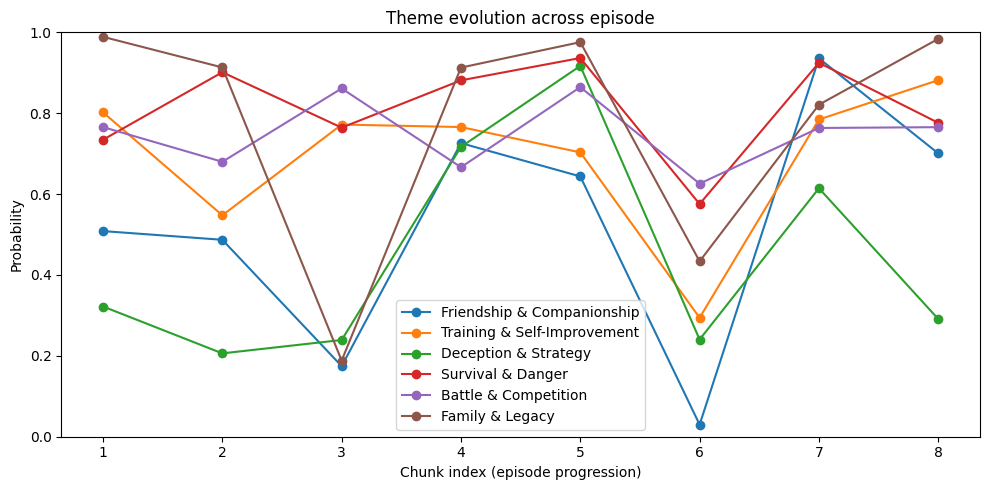

In [28]:
probs_matrix = plot_episode_theme_evolution(script_ep1, theme_classifeir, theme_list, chunk_size=1000)


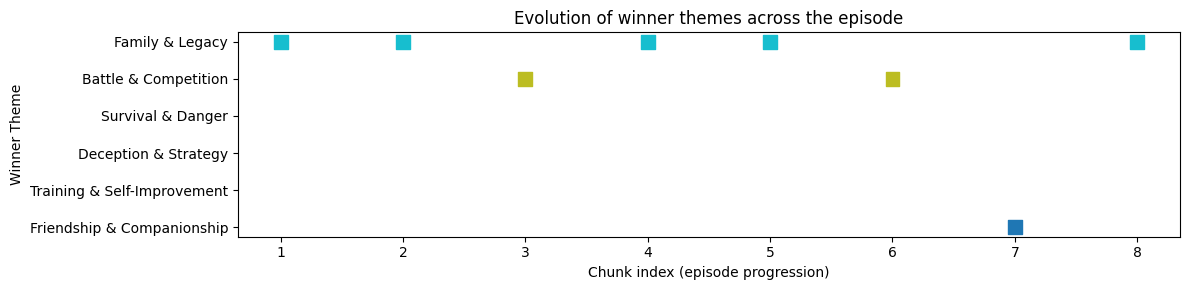

In [29]:
winner_timeline = plot_episode_winner_timeline(
    script_ep1, theme_classifeir, theme_list, chunk_size=1000
)


# Another idea we can try is fine-tuning an LLM to generate titles for the episodes based on their subtitles.

* ### let's clean the dataset, mapped episode ids to story arcs, then randomly split it keeping 5 to 10 episodes for stratified test set(so arcs are covered) and shuffling to avoid chronologial leakage.
* ### for each row , we create the input from the subtitle and set the true title as target , and returning train , test and  a hugging face dataset ready for LLm trainer

In [16]:
from datasets import Dataset, DatasetDict

In [17]:
ARC_RANGES = [
    (1, 21,  "Hunter Exam"),
    (22, 26, "Zoldyck Family"),
    (27, 36, "Heavens Arena"),
    (37, 58, "Yorknew City"),
    (59, 75, "Greed Island"),
    (76, 136,"Chimera Ant"),
    (137,148,"Election"),
]

In [32]:
def map_arc(ep_id: int) -> str:
    for lo, hi, arc in ARC_RANGES:
        if lo <= ep_id <= hi:
            return arc
    return "Unknown"

def build_splits_for_title_gen(df: pd.DataFrame, n_test: int = 10,
                               seed: int = 42, stratify_by_arc: bool = True):
    # keep only rows with both fields
    d = df.dropna(subset=["subtitle","title"]).copy()
    d["id"] = pd.to_numeric(d["id"], errors="coerce").astype(int)
    d["arc"] = d["id"].apply(map_arc)
    d = d[d["arc"] != "Unknown"]

    # global shuffle
    d = d.sample(frac=1, random_state=seed).reset_index(drop=True)

    # n_test guard (leave at least 1 train sample)
    n_test = int(min(max(n_test, 1), len(d) - 1))

    # ---- choose test indices (stratified by arc when possible) ----
    if stratify_by_arc:
        arcs = d["arc"].unique().tolist()
        test_idx = []

        if n_test >= len(arcs):
            # 1 per arc, then fill the remainder at random
            for arc in arcs:
                test_idx.append(d[d["arc"] == arc].sample(n=1, random_state=seed).index[0])
            remaining = n_test - len(test_idx)
            if remaining > 0:
                rest = d.drop(index=test_idx)
                test_idx += rest.sample(n=remaining, random_state=seed).index.tolist()
        else:
            # pick n_test arcs at random, one episode from each
            chosen_arcs = pd.Series(arcs).sample(n=n_test, random_state=seed)
            for arc in chosen_arcs:
                test_idx.append(d[d["arc"] == arc].sample(n=1, random_state=seed).index[0])
    else:
        test_idx = d.sample(n=n_test, random_state=seed).index.tolist()

    test_df  = d.loc[test_idx]
    train_df = d.drop(index=test_idx)

    # final shuffle + reindex
    test_df  = test_df.sample(frac=1, random_state=seed).reset_index(drop=True)
    train_df = train_df.sample(frac=1, random_state=seed).reset_index(drop=True)

    # ---- build instruction-format fields ----
    prefix =(
        "You are tasked with writing a Hunter x Hunter style episode title. "
        "Hunter x Hunter titles always follow the unique format of short phrases "
        "separated by ' x '. Usually there are exactly three parts (each 1–2 words), "
        "like these examples:\n"
        "- Hope x And x Ambition\n"
        "- Rivals x For x Survival\n"
        "- Hisoka x Is x Sneaky\n"
        "- A x Brutal x Battlefield\n\n"
        "Now, based on the following episode summary, create a new title in the same style.\n"
        "\nTitle:"
    )

    for tmp in (train_df, test_df):
        tmp["input"]  = prefix + "Subtitle: " + tmp["subtitle"].astype(str) + "\nTitle:"
        tmp["target"] = tmp["title"].astype(str)
    ds = DatasetDict({
        "train": Dataset.from_pandas(train_df[["input","target"]]),
        "test":  Dataset.from_pandas(test_df[["input","target"]]),
    })
    return train_df, test_df, ds

In [33]:
train_df, test_df, ds = build_splits_for_title_gen(df, n_test=10, seed=42, stratify_by_arc=True)

In [34]:
print(train_df.shape, test_df.shape)
print(test_df["arc"].value_counts())

(135, 6) (10, 6)
arc
Chimera Ant       3
Yorknew City      2
Election          1
Greed Island      1
Heavens Arena     1
Hunter Exam       1
Zoldyck Family    1
Name: count, dtype: int64


In [35]:
train_df.head()

,id,title,subtitle,arc,input,target
0,142,Defeat x And x Reunion,The results of the eighth chairman election we...,Election,You are tasked with writing a Hunter x Hunter ...,Defeat x And x Reunion
1,6,A x Surprising x Challenge,Looks like we made it in time. Leorio... Leori...,Hunter Exam,You are tasked with writing a Hunter x Hunter ...,A x Surprising x Challenge
2,91,One Wish x And x Two Promises,"Colt arrived, under a white flag of surrender,...",Chimera Ant,You are tasked with writing a Hunter x Hunter ...,One Wish x And x Two Promises
3,32,A x Surprising x Win,Kastro has used Nen to create a double of hims...,Heavens Arena,You are tasked with writing a Hunter x Hunter ...,A x Surprising x Win
4,86,Promise x and x Reunion,Gon and Killua have vowed to save Kite. But be...,Chimera Ant,You are tasked with writing a Hunter x Hunter ...,Promise x and x Reunion


In [36]:
test_df.head()

,id,title,subtitle,arc,input,target
0,92,Date x With x Palm,I don't know which nation sent you. But having...,Chimera Ant,You are tasked with writing a Hunter x Hunter ...,Date x With x Palm
1,140,Sin x And x Claw,5th Election for the 13th Chairman In the fift...,Election,You are tasked with writing a Hunter x Hunter ...,Sin x And x Claw
2,118,Strong x Or x Weak,He disappeared? Godspeed. The difference in in...,Chimera Ant,You are tasked with writing a Hunter x Hunter ...,Strong x Or x Weak
3,70,Guts x And x Courage,An intense dodgeball match has begun. Gon was ...,Greed Island,You are tasked with writing a Hunter x Hunter ...,Guts x And x Courage
4,39,Wish x And x Promise,"As Gon and Killua depart from Whale Island, Ku...",Yorknew City,You are tasked with writing a Hunter x Hunter ...,Wish x And x Promise


In [37]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['input', 'target'],
        num_rows: 135
    })
    test: Dataset({
        features: ['input', 'target'],
        num_rows: 10
    })
})


In [38]:
train_df.iloc[0].input

'You are tasked with writing a Hunter x Hunter style episode title. Hunter x Hunter titles always follow the unique format of short phrases separated by \' x \'. Usually there are exactly three parts (each 1–2 words), like these examples:\n- Hope x And x Ambition\n- Rivals x For x Survival\n- Hisoka x Is x Sneaky\n- A x Brutal x Battlefield\n\nNow, based on the following episode summary, create a new title in the same style.\n\nTitle:Subtitle: The results of the eighth chairman election were promptly counted by Beans. Now, please take a look at the result of the eighth election for the 13th chairman! Wow! Eighth Election for the 13th Chairman 1) Leorio 282 (44.4%) 2) Pariston 250 3) Mizaistom 58 4) Cheadle 16 Turnout: 95.4% This puts Leorio in first place! For the first time, Pariston hasn\'t finished in first place... However, the first place vote-getter, Leorio, received only 44.4% of the vote. That was below the 50% requirement, which means we\'ll finally have a run-off between the 

## let's see the performance of the LLM without fine tuning 

In [39]:
import re, torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

* ### we will use flan-t5-small from goolge for this task:
* #### becaues it's an encoder decoder model that excels at conditional generation tasks, and its intructions-tuning makes it follow prompts much better than vanella T5 or decoder only models like llama or qwen, finally it's small and lightweight , it trains and runs easly on limited data like ours (145 samples )without over fittnig.

In [40]:
base_ckpt = "google/flan-t5-small" # context window 512 tokens
tok = tok if 'tok' in globals() else AutoTokenizer.from_pretrained(base_ckpt)
model_zs = AutoModelForSeq2SeqLM.from_pretrained(base_ckpt).to("cuda" if torch.cuda.is_available() else "cpu").eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [41]:
enc = tok(test_df["input"].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=256).to(model_zs.device)
out = model_zs.generate(**enc, max_length=16, num_beams=4, no_repeat_ngram_size=2)
preds = tok.batch_decode(out, skip_special_tokens=True)

# tiny cleanup
test_df["pred_zero_shot"] = [re.sub(r'^\s*title\s*:\s*','', p, flags=re.I) for p in preds]

print(test_df[["id","title","pred_zero_shot"]].head(10).to_string(index=False))

 id                       title                                    pred_zero_shot
 92          Date x With x Palm                                   Hunter x Hunter
140            Sin x And x Claw                5th Election for the 13th Chairman
118          Strong x Or x Weak                          He disappeared? Godspeed
 70        Guts x And x Courage                                   Hunter x Hunter
 39        Wish x And x Promise           Gon and Killua depart from Whale Island
 33         An x Empty x Threat                                   Hunter x Hunter
113      Divide x And x Conquer                                   Hunter x Hunter
 43      A x Shocking x Tragedy                            A Brutal x Battlefield
 20 Baffling x Turn Of x Events You're awake? Where am I? A waiting room, next to
 26          Then x And x After                                   Hunter x Hunter


* ## The zero-shot FLAN-T5 outputs mostly respect the format but collapse to generic phrases like “Hunter x Hunter” or malformed text

* we can notice that each episode has around 8000 char, so it's around 2000 tokens , the T5 model can't read them at once to it ignores the remaining text
* to solve this let's try an other idea, it could improve the performance of zero_shot approach
* we can also use more robust model the flan-t5-base with 80M param 

In [42]:
base_ckpt = "google/flan-t5-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

tok = AutoTokenizer.from_pretrained(base_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(base_ckpt).to(device).eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [43]:
def split_into_parts(text, num_parts=4):
    # Encode without cutting, but avoid the 512-token warning
    ids = tok.encode(text or "", add_special_tokens=False,
                     truncation=True, max_length=10**6)
    n = len(ids)
    if n == 0:
        return [""] * num_parts
    # roughly equal parts (ceil division)
    part_len = (n + num_parts - 1) // num_parts
    parts_ids = [ids[i:i+part_len] for i in range(0, n, part_len)][:num_parts]
    return [tok.decode(p, skip_special_tokens=True) for p in parts_ids]


def summarize(text, max_len=256):
    """Summarize text into at most `max_len` tokens"""
    enc = tok(f"Summarize: {text}", return_tensors="pt",
              truncation=True, max_length=512).to(device)
    out = model.generate(**enc, max_length=max_len, num_beams=4)
    return tok.decode(out[0], skip_special_tokens=True)

def summarize_long_script(script):
    # 1) split into 4 parts
    parts = split_into_parts(script, num_parts=4)

    # 2) summarize each part (≤256 tokens)
    part_summaries = [summarize(p, max_len=256) for p in parts]

    # 3) combine them
    combined = " ".join(part_summaries)

    # 4) final summary (≤500 tokens)
    return summarize(combined, max_len=500)

def enforce_hxh_style(title: str) -> str:
    title = re.sub(r'^\s*title\s*:\s*', '', title, flags=re.I).strip()
    title = re.sub(r'\s+', ' ', title).strip()

    words = title.split()[:6]
    if len(words) < 3:
        while len(words) < 3:
            words.append("Something")

    n = len(words)
    part1 = " ".join(words[: max(1, n//3)])
    part2 = " ".join(words[max(1, n//3): max(2, 2*n//3)])
    part3 = " ".join(words[max(2, 2*n//3):])
    return f"{part1.title()} x {part2.title()} x {part3.title()}"

def generate_title(script):
    summary = summarize_long_script(script)

    # improved prompt with examples
    prompt = (
        "You are tasked with writing a Hunter x Hunter style episode title. "
        "Hunter x Hunter titles always follow the unique format of short phrases "
        "separated by ' x '. Usually there are exactly three parts (each 1–2 words), "
        "like these examples:\n"
        "- Hope x And x Ambition\n"
        "- Rivals x For x Survival\n"
        "- Hisoka x Is x Sneaky\n"
        "- A x Brutal x Battlefield\n\n"
        "Now, based on the following episode summary, create a new title in the same style.\n"
        f"Summary: {summary}\n"
        "Title:"
    )

    enc = tok(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
    out = model.generate(**enc, max_length=16, num_beams=4)
    raw_title = tok.decode(out[0], skip_special_tokens=True)

    return enforce_hxh_style(raw_title)


In [48]:
test_df["pred_title"] = test_df["subtitle"].apply(generate_title)
print(test_df[["id","title","pred_title"]].head(10).to_string(index=False))

 id                       title                                 pred_title
 92          Date x With x Palm            Gon And x Killua Are x On Their
140            Sin x And x Claw             If There'S x No Limit x On The
118          Strong x Or x Weak    Youpi Has x Disappeared, As x Though He
 70        Guts x And x Courage Gon'S Inside x Players Control x The Ball.
 39        Wish x And x Promise              Learn How x To Make x A Sword
 33         An x Empty x Threat     Gon-Kun: I'M x Pleased That x You Kept
113      Divide x And x Conquer         Gon, x Grandpa. Gon, x Grandpa. Go
 43      A x Shocking x Tragedy Kurapika And x The Other x Bodyguards Have
 20 Baffling x Turn Of x Events      Gon-Kun, You x Can'T Destroy x Or Put
 26          Then x And x After           Gon x Freecss: Gon x Freecss: Go


### this shows that the "flan-t5-base model with the summurazation trick gives very acceptable result: let's try to fine tune it to get better performance

### * let's first prepare the data by summarize the subtitles and prepare the input 

In [14]:
import torch, re, math, pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [15]:
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_ENABLE_TELEMETRY"] = "0"

In [76]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [80]:
# We choose "facebook/bart-large-cnn" because:
# - It is trained specifically for summarization tasks.
# - It handles longer contexts (≈1024 tokens) compared to flan-t5-base (512).
# - It produces fluent, high-quality narrative summaries.
# - It is faster and lighter than long-T5 (4096 ctx), so good balance of quality and efficiency.
# 
# Note: subtitles are ~8000 tokens → we will still chunk into smaller blocks (e.g. 500 tokens each),
#       summarize them individually, and then fuse the partial summaries into one short narrative.

sum_tok = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
sum_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn").to(device).eval()

SUM_MAX = 1024   # maximum context window size of bart-large-cnn
print("Using summarizer: bart-large-cnn (≈1024 ctx)")

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Using summarizer: bart-large-cnn (≈1024 ctx)


In [92]:
@torch.no_grad() # ithout gradiant tracking , 
def _summarize_once(text: str, max_src: int, max_new: int) -> str:
    """
    Summarize subtitles into a narrative (3–5 sentences).
    Uses clear input markers so the model doesn't echo the instruction.
    """
    instruction = (
        "Instruction: Convert the subtitles into a concise narrative summary.\n"
        "- Write 3–5 sentences (80–120 words).\n"
        "- Focus on actions, goals, conflicts, turning points, and outcomes.\n"
        "- Merge dialogue into narration, no quotes or bullet points.\n"
        "- Keep character names, no invented facts.\n\n"
    )
    prompt = instruction + "Subtitles:\n" + (text or "") + "\n\nNarrative:"

    # Tokenize + truncate from the LEFT so we keep the end of subtitles
    enc = sum_tok(prompt, return_tensors="pt",
                  truncation=True, max_length=max_src,
                  padding=False).to(device)

    out = sum_model.generate(**enc,
                             max_new_tokens=max_new,
                             num_beams=4,
                             no_repeat_ngram_size=3)

    return sum_tok.decode(out[0], skip_special_tokens=True).strip()

def _chunk_by_tokens(text: str, chunk_size: int = 500):
    """
    Split text into ~chunk_size token blocks.
    """
    ids = sum_tok.encode(text or "", add_special_tokens=False)
    return [
        sum_tok.decode(ids[i:i+chunk_size], skip_special_tokens=True)
        for i in range(0, len(ids), chunk_size)
    ]

def summarize_dialogue_to_narrative(text: str) -> str:
    """
    If short → summarize directly.
    If long (≈8000 tokens) → split → partial summaries → fused summary.
    """
    ids = sum_tok.encode(text or "", add_special_tokens=False)
    if len(ids) <= SUM_MAX - 50:  # safe margin
        return _summarize_once(text, max_src=SUM_MAX-20, max_new=160)

    # Step 1: chunk into small blocks (≈500 tokens)
    chunks = _chunk_by_tokens(text, chunk_size=min(500, SUM_MAX-50))

    # Step 2: summarize each block
    partials = [_summarize_once(c, max_src=SUM_MAX-20, max_new=120) for c in chunks]

    # Step 3: fuse into single summary
    fused = " ".join(partials)
    return _summarize_once(fused, max_src=SUM_MAX-20, max_new=200)

# ---------- Title prompt ----------
def build_title_prompt(summary: str) -> str:
    return (
        "You are tasked with writing a Hunter x Hunter style episode title. "
        "Use short phrases separated by ' x '. Exactly three parts (1–2 words each).\n"
        "Examples: Hope x And x Ambition ; Rivals x For x Survival ; Hisoka x Is x Sneaky.\n\n"
        f"Summary: {summary}\nTitle:"
    )

def enforce_hxh_style(title: str) -> str:
    t = re.sub(r'^\s*title\s*:\s*', '', str(title), flags=re.I).strip()
    t = re.sub(r'\s+', ' ', t)
    words = t.split()[:6]
    while len(words) < 3:
        words.append("Something")
    n = len(words)
    p1 = " ".join(words[:max(1, n//3)])
    p2 = " ".join(words[max(1, n//3): max(2, 2*n//3)])
    p3 = " ".join(words[max(2, 2*n//3):])
    return f"{p1.title()} x {p2.title()} x {p3.title()}"


In [93]:
train_df = train_df.copy()
test_df  = test_df.copy()

In [94]:
train_df["subtitle"] = train_df["subtitle"].fillna("")
test_df["subtitle"]  = test_df["subtitle"].fillna("")

train_df["summary"]  = train_df["subtitle"].apply(summarize_dialogue_to_narrative)
test_df["summary"]   = test_df["subtitle"].apply(summarize_dialogue_to_narrative)

train_df["input"]  = train_df["summary"].apply(build_title_prompt)
test_df["input"]   = test_df["summary"].apply(build_title_prompt)

train_df["target"] = train_df["title"].astype(str)
test_df["target"]  = test_df["title"].astype(str)

In [95]:
train_df[["id","title","summary","input"]].head(2)


,id,title,summary,input
0,142,Defeat x And x Reunion,"Pariston asks Leorio-san: ""Can you please give...",You are tasked with writing a Hunter x Hunter ...
1,6,A x Surprising x Challenge,Gourmet Hunters Menchi and Buhara are examiner...,You are tasked with writing a Hunter x Hunter ...


In [96]:
train_df.summary[0]

'Pariston asks Leorio-san: "Can you please give us your answer again? What will you do if you become chairman?" Leorio: "I was the only one in favor of revising the Ten Commandments" Pariston: "It hurts to admit this, but I\'ve been defeated. It was when Ging-san said he would run for chairman"'

In [97]:
train_df.summary[4]

'Gon and Killua have vowed to save Kite. They take a piece of marked wood and split it, giving each half to a different person. Each of the two assassins holds one matching token. Knuckle Bine challenges Knuckle and Shoot to a duel. The deadline is one month.'

In [113]:
import re

def is_bad_summary(text: str) -> bool:
    """
    Detect summaries that look like instructions instead of real summaries.
    Returns True if the text is 'bullshit', False if it's a proper summary.
    """
    if not text or len(text.strip()) < 20:
        return True
    
    # Lowercase for easier matching
    t = text.lower()
    
    # Common instruction words that shouldn't appear in real summaries
    bad_patterns = [
        r"^instruction", r"^writer", r"^write", r"^convert",
        r"^summarize", r"^merge", r"^focus on",
        r"no quotes", r"bullet points", r"for more information",
    ]
    
    for pat in bad_patterns:
        if re.search(pat, t):
            return True
    
    return False

# Apply to dataframe
train_df["is_bad"] = train_df["summary"].apply(is_bad_summary)

# Count stats
n_bad = train_df["is_bad"].sum()
n_good = len(train_df) - n_bad

print(f"Good summaries: {n_good}")
print(f"Bad summaries (instruction echoes): {n_bad}")
print(f"Percentage bad: {n_bad/len(train_df)*100:.1f}%")


Good summaries: 72
Bad summaries (instruction echoes): 63
Percentage bad: 46.7%


In [114]:
# Show 5 random bad summaries
bad_examples = train_df[train_df["is_bad"]].sample(5, random_state=42)
print(bad_examples[["id", "target", "summary"]].to_string(index=False))


 id                   target                                                                                                                                                                                                                                                                                                                                              summary
  4    Hope x And x Ambition Instruction: Convert the subtitles into a concise narrative summary. Write 3–5 sentences (80–120 words) Focus on actions, goals, conflicts, turning points, and outcomes. Merge dialogue into narration, no quotes or bullet points. Keep character names, no invented facts. Use the Hunter Vocabulary Killua to help students understand the game.
127     Magic x Of x Despair                                                                                       Writer: Write 3–5 sentences (80–120 words) Merge dialogue into narration, no quotes or bullet points. Keep character names, no invented facts. Su

In [115]:
# Show 5 random good summaries
good_examples = train_df[~train_df["is_bad"]].sample(5, random_state=42)
print(good_examples[["id", "target", "summary"]].to_string(index=False))


 id                   target                                                                                                                                                                                                                                                                                                                                                    summary
134 Debate X Among X Zodiacs                                                                                            The Zodiacs meet to elect a new chairman for East Gorteau. The Rat is missing, and the Vice Chairman is too busy to lead the meeting. The dragon Botobai can't accept that the chairman didn't call us to help. The dog Cheadle wants to hunt the Ants himself.
 62      Reality x And x Raw                                                                             A map that automatically fills in locations as the owner visits and gathers information about them. Greed Island is a trap that sends players w

In [116]:
test_df["is_bad"] = test_df["summary"].apply(is_bad_summary)

# Count stats
n_bad = test_df["is_bad"].sum()
n_good = len(test_df) - n_bad

print(f"Good summaries: {n_good}")
print(f"Bad summaries (instruction echoes): {n_bad}")
print(f"Percentage bad: {n_bad/len(test_df)*100:.1f}%")


Good summaries: 6
Bad summaries (instruction echoes): 4
Percentage bad: 40.0%


* ### let's try fine tune the flan-T5-base model on only the good summary , to test the pipeline then if it works good and gives good results we can return and amiliorate the summarization pipeline

***

# <span style = 'color  :red'> after examining the results of the finetuening of flan-t5-base using this trick of summarization, we got bad results and the model gives random titles, so i thought that we can try the following idea : </span>

# * slide the text of 8000 tokens with a window of 512 tokens and a stride of 400 tokens and for every chunk we let the model genereate a title that we add to the prompt with the second chunk and so and so forth
# * we can also make it easier to the model by removeing the 'x's in the titles and focus only on the title meaning 

In [18]:
df.head()

,id,title,subtitle
0,1,Departure x And x Friends,Whale Island Gon's still trying to catch the L...
1,2,Test x Of x Tests,Dolle Harbor After winning the captain's favor...
2,3,Rivals x For x Survival,Zaban City Gon and his new friends have arrive...
3,4,Hope x And x Ambition,Two hours have passed since the start of the e...
4,5,Hisoka x Is x Sneaky,The 368 applicants who made it through the lon...


In [19]:
df.shape

(145, 3)

In [20]:
# Clean the titles: replace " x " with space and strip extra spaces
df["target"] = df["title"].str.replace(r"\s*x\s*", " ", regex=True).str.strip()

# Preview
print(df[["title", "target"]].head())


                       title                 target
0  Departure x And x Friends  Departure And Friends
1          Test x Of x Tests          Test Of Tests
2    Rivals x For x Survival    Rivals For Survival
3      Hope x And x Ambition      Hope And Ambition
4       Hisoka x Is x Sneaky       Hisoka Is Sneaky


In [21]:
df.head()

,id,title,subtitle,target
0,1,Departure x And x Friends,Whale Island Gon's still trying to catch the L...,Departure And Friends
1,2,Test x Of x Tests,Dolle Harbor After winning the captain's favor...,Test Of Tests
2,3,Rivals x For x Survival,Zaban City Gon and his new friends have arrive...,Rivals For Survival
3,4,Hope x And x Ambition,Two hours have passed since the start of the e...,Hope And Ambition
4,5,Hisoka x Is x Sneaky,The 368 applicants who made it through the lon...,Hisoka Is Sneaky


In [22]:
from datasets import Dataset, DatasetDict

In [23]:
SEED = 42
np.random.seed(SEED)

df = df[['subtitle','target']].dropna().reset_index(drop=True)

In [24]:
df.head()

,subtitle,target
0,Whale Island Gon's still trying to catch the L...,Departure And Friends
1,Dolle Harbor After winning the captain's favor...,Test Of Tests
2,Zaban City Gon and his new friends have arrive...,Rivals For Survival
3,Two hours have passed since the start of the e...,Hope And Ambition
4,The 368 applicants who made it through the lon...,Hisoka Is Sneaky


In [25]:
# 125 train / 10 eval / 10 test
df_shuf = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
train_df = df_shuf.iloc[:125].reset_index(drop=True)
eval_df  = df_shuf.iloc[125:135].reset_index(drop=True)
test_df  = df_shuf.iloc[135:145].reset_index(drop=True)

In [26]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

model_id = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

# Base model for pseudo previous titles (no finetuning)
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device).eval()

# Finetuning model
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [27]:
MAX_INPUT_LEN = 512
STRIDE        = 400
LAST_K        = 1

TITLE_PROMPT = (
    "titleize: Generate a short anime episode title in Title Case (3–8 words). "
    "Base it only on the provided context. Output only the title."
)

def make_windows(text: str):
    ids = tokenizer(text, add_special_tokens=False).input_ids
    if not ids: return [""]
    windows, start = [], 0
    while True:
        chunk_ids = ids[start:start + MAX_INPUT_LEN]
        if not chunk_ids: break
        windows.append(tokenizer.decode(chunk_ids, skip_special_tokens=True))
        if start + MAX_INPUT_LEN >= len(ids): break
        start += STRIDE
    return windows

@torch.no_grad()
def title_from_single_window(win_text: str) -> str:
    """Pseudo previous title from a single window using the *base* model."""
    prompt = f"{TITLE_PROMPT}\nContext:\n{win_text}"
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_INPUT_LEN).to(device)
    out = base_model.generate(**enc, num_beams=4, max_new_tokens=24)
    return tokenizer.decode(out[0], skip_special_tokens=True)

In [28]:
def build_examples(df_split: pd.DataFrame, last_k: int = 1):
    inputs, labels = [], []
    for sub, title in zip(df_split["subtitle"], df_split["target"]):
        wins = make_windows(str(sub))
        if not wins: continue
        # indices of last-K windows
        start_idx = max(0, len(wins) - last_k)
        for j in range(start_idx, len(wins)):
            prev_title = ""
            if j-1 >= 0:
                # pseudo previous title from previous window (no gold leakage)
                prev_title = title_from_single_window(wins[j-1])
            if prev_title:
                prompt = f"{TITLE_PROMPT}\nPrevious title: {prev_title}\nContext:\n{wins[j]}"
            else:
                prompt = f"{TITLE_PROMPT}\nContext:\n{wins[j]}"
            inputs.append(prompt)
            labels.append(str(title))
    return Dataset.from_dict({"inp": inputs, "lbl": labels})

train_examples = build_examples(train_df, last_k=LAST_K)
eval_examples  = build_examples(eval_df,  last_k=LAST_K)

# After precomputing, free base model if memory is tight
del base_model
if torch.cuda.is_available(): torch.cuda.empty_cache()

Token indices sequence length is longer than the specified maximum sequence length for this model (2534 > 512). Running this sequence through the model will result in indexing errors


In [29]:
tok_targets = tokenizer([str(t) for t in train_df["target"].tolist()], truncation=True)
max_target_length = min(64, max(len(x) for x in tok_targets["input_ids"]))

def tokenize_examples(dset):
    dset = dset.map(
        lambda b: {
            **tokenizer(b["inp"], max_length=MAX_INPUT_LEN, padding="max_length", truncation=True),
            "labels": tokenizer(b["lbl"], max_length=max_target_length, padding="max_length", truncation=True)["input_ids"]
        },
        batched=True, remove_columns=["inp","lbl"]
    )
    # replace pad with -100 in labels
    dset = dset.map(lambda b: {"labels": [[(t if t != tokenizer.pad_token_id else -100) for t in x] for x in b["labels"]]},
                    batched=True)
    return dset

tokenized_train = tokenize_examples(train_examples)
tokenized_eval  = tokenize_examples(eval_examples)

from datasets import DatasetDict
tokenized_dataset = DatasetDict({"train": tokenized_train, "eval": tokenized_eval})

print("Train samples:", len(tokenized_dataset["train"]))
print("Eval samples :", len(tokenized_dataset["eval"]))
print("Features    :", tokenized_dataset["train"].features)

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Train samples: 125
Eval samples : 10
Features    : {'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [31]:
pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [32]:
pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d66a2efb084eb25dd5fa520ac2fb18baecbadec74df672f6d38aa544039dc5da
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [33]:
import evaluate
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

metric = evaluate.load("rouge")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
import evaluate, nltk, numpy as np
from nltk.tokenize import sent_tokenize
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds  = ["\n".join(sent_tokenize(p.strip())) for p in preds]
    labels = ["\n".join(sent_tokenize(l.strip())) for l in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple): preds = preds[0]
    decoded_preds  = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    out = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    out = {k: round(v * 100, 4) for k, v in out.items()}
    gen_lens = [np.count_nonzero(p != tokenizer.pad_token_id) for p in preds]
    out["gen_len"] = float(np.mean(gen_lens))
    return out

from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, model=model, label_pad_token_id=-100, pad_to_multiple_of=8
)

In [35]:
from transformers import DataCollatorForSeq2Seq
label_pad_token_id = -100

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [43]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from huggingface_hub import HfFolder
from transformers import EarlyStoppingCallback

repository_id = "flan-t5-base-hxh-titles-lastK"

training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=max_target_length,
    fp16=False,
    learning_rate=5e-5,
    num_train_epochs=10,

    # ---- FIX LOGGING ----
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",


    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="tensorboard",
    push_to_hub=False,
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["eval"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [44]:
# Free as much GPU memory as possible
import gc, torch

def free_gpu(*objs, verbose=True):
    """
    Move models off GPU, delete references, and clear CUDA caches.
    Pass any model/optimizer/trainer/accelerator objects as args.
    """
    # 1) Move models to CPU first
    for obj in objs:
        try:
            if hasattr(obj, "to"): obj.to("cpu")
        except Exception:
            pass

    # 2) Drop references
    for obj in objs:
        try:
            del obj
        except Exception:
            pass

    # 3) Python & CUDA GC
    gc.collect()
    if torch.cuda.is_available():
        try: torch.cuda.synchronize()
        except Exception: pass
        torch.cuda.empty_cache()
        try: torch.cuda.ipc_collect()
        except Exception: pass
        if verbose:
            allocated = torch.cuda.memory_allocated() / (1024**2)
            reserved  = torch.cuda.memory_reserved()  / (1024**2)
            print(f"[GPU] allocated: {allocated:.1f} MB | reserved: {reserved:.1f} MB")
            # print(torch.cuda.memory_summary(abbreviated=True))

    try:
        import cupy as cp
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()
        if verbose: print("[CuPy] memory pools freed.")
    except Exception:
        pass


In [45]:
free_gpu(trainer, model)
# free_gpu(trainer, model, base_model, optimizer, lr_scheduler, scaler, accelerator)


[GPU] allocated: 1933.3 MB | reserved: 2138.0 MB
[CuPy] memory pools freed.


In [46]:
# it was trained for 5 epochs and gave training loss 4.3 so we train for more epochs with earlystoppingcallback
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.808000,4.237364,7.833300,0.000000,7.833300,7.833300,6.000000
2,2.709000,4.343635,10.333300,0.000000,10.333300,10.333300,6.300000
3,2.561300,4.397120,10.833300,0.000000,10.833300,10.833300,5.700000


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=48, training_loss=2.6927520434061685, metrics={'train_runtime': 45.9062, 'train_samples_per_second': 27.229, 'train_steps_per_second': 3.485, 'total_flos': 256784007168000.0, 'train_loss': 2.6927520434061685, 'epoch': 3.0})

In [49]:
pip install bert_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvi

# the data is too small (125 episodes) to make the llm generate exactly the same titles, so we will use bert score to evaluate.
* ##  ROUGE = “Do we share the same words/phrases?”

- ## BERTScore = “Do we mean the same thing, even if words differ?”

In [ ]:
# ==== TEST AFTER FINETUNING (self-contained) ====
import torch, numpy as np, pandas as pd, evaluate, nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt", quiet=True)

# 0) Ensure tokenizer exists (reuse if already defined)
try:
    tokenizer  # noqa: F821
except NameError:
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base", use_fast=True)

if "test_df" not in globals():
    if "df" in globals():
        SEED = 42
        df_shuf = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
        train_df = df_shuf.iloc[:125].reset_index(drop=True)
        eval_df  = df_shuf.iloc[125:135].reset_index(drop=True)
        test_df  = df_shuf.iloc[135:145].reset_index(drop=True)
    else:
        raise RuntimeError("`test_df` not found and `df` is not available to build it. Define one with columns: subtitle,target.")

model = trainer.model
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TITLE_PROMPT = (
    "titleize: Generate a short anime episode title in Title Case (3–8 words). "
    "Base it only on the provided context. Output only the title."
)

MAX_INPUT_LEN = 512
STRIDE        = 400

def generate_title_sliding(subtitle: str,
                           model,
                           tokenizer,
                           max_input_len: int = MAX_INPUT_LEN,
                           stride: int = STRIDE,
                           num_beams: int = 4,
                           max_new_tokens: int = 24):
    """Iterative generation with previous-title carry-over."""
    ids = tokenizer(subtitle, add_special_tokens=False).input_ids
    prev_title, start = "", 0
    while True:
        chunk_ids = ids[start:start + max_input_len]
        if not chunk_ids:
            break
        chunk_text = tokenizer.decode(chunk_ids, skip_special_tokens=True)
        prompt = (f"{TITLE_PROMPT}\nPrevious title: {prev_title}\nContext:\n{chunk_text}"
                  if prev_title else
                  f"{TITLE_PROMPT}\nContext:\n{chunk_text}")
        enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_input_len).to(device)
        with torch.no_grad():
            out = model.generate(
                **enc,
                num_beams=num_beams,
                max_new_tokens=max_new_tokens,
                no_repeat_ngram_size=3,
                length_penalty=1.0
            )
        prev_title = tokenizer.decode(out[0], skip_special_tokens=True)
        if start + max_input_len >= len(ids):
            break
        start += stride
    return prev_title

# 3) Build predictions and references
test_texts = test_df["subtitle"].tolist()
test_refs  = test_df["target"].tolist()
test_preds = [generate_title_sliding(s, model, tokenizer) for s in test_texts]

# 4) Metrics (ROUGE + BERTScore)
def postprocess_text(preds, labels):
    preds  = ["\n".join(sent_tokenize(p.strip())) for p in preds]
    labels = ["\n".join(sent_tokenize(l.strip())) for l in labels]
    return preds, labels

metric = evaluate.load("rouge")
pp_preds, pp_refs = postprocess_text(test_preds, test_refs)
rouge = metric.compute(predictions=pp_preds, references=pp_refs, use_stemmer=True)
rouge = {k: round(v * 100, 2) for k, v in rouge.items()}

from bert_score import score as bert_score
P, R, F1 = bert_score(test_preds, test_refs, lang="en", rescale_with_baseline=True)
bertscore_f1 = [round(x * 100, 2) for x in F1.tolist()]
avg_bertscore = float(np.mean(F1) * 100)

print("TEST ROUGE:", rouge)
print(f"Average BERTScore-F1: {avg_bertscore:.2f}%")

# 5) Display table
tbl = pd.DataFrame({
    "idx": range(len(test_preds)),
    "pred": test_preds,
    "true": test_refs,
    "BERTScore-F1": bertscore_f1
})

try:
    from IPython.display import display
    display(tbl.style
            .set_caption("HXH Titles — Predictions vs Ground Truth (with BERTScore)")
            .background_gradient(subset=["BERTScore-F1"], cmap="Greens"))
except Exception:
    print(tbl.to_string(index=False))


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TEST ROUGE: {'rouge1': 18.48, 'rouge2': 0.0, 'rougeL': 18.48, 'rougeLsum': 18.48}
Average BERTScore-F1: 16.77%


,idx,pred,true,BERTScore-F1
0,0,Awakening And Attack,Compassion And Strength,27.460000
1,1,A Name And A Name,Ging's Friends And True Friends,13.420000
2,2,Awakening And Rebirth,Centipede And Memory,0.190000
3,3,A Chance To Be A Hunter,Past And Future,2.410000
4,4,An Enigma And A Mystery,Some Brother Trouble,1.920000
5,5,Awakening And Power,Chase And Chance,49.990000
6,6,Awakening And Resurrection,Gungi Of Komugi,-9.850000
7,7,Final Wish And Final Point,E plosion Of Deception,-3.300000
8,8,Awakening And Rebirth,Friend And Journey,62.300000
9,9,Awakening And Power,Doubt And Hesitation,23.160000


In [51]:
base_model_id = "google/flan-t5-base"
base_tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True)
base_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device).eval()

TITLE_PROMPT = (
    "titleize: Generate a short anime episode title in Title Case (3–8 words). "
    "Base it only on the provided context. Output only the title."
)

MAX_INPUT_LEN = 512
STRIDE = 400

def generate_title_sliding_base(subtitle: str,
                                model,
                                tokenizer,
                                max_input_len: int = MAX_INPUT_LEN,
                                stride: int = STRIDE,
                                num_beams: int = 4,
                                max_new_tokens: int = 24):
    """Same sliding-window with carry-over, but using base model."""
    ids = tokenizer(subtitle, add_special_tokens=False).input_ids
    prev_title, start = "", 0
    while True:
        chunk_ids = ids[start:start + max_input_len]
        if not chunk_ids: break
        chunk_text = tokenizer.decode(chunk_ids, skip_special_tokens=True)
        prompt = (f"{TITLE_PROMPT}\nPrevious title: {prev_title}\nContext:\n{chunk_text}"
                  if prev_title else f"{TITLE_PROMPT}\nContext:\n{chunk_text}")
        enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_input_len).to(device)
        with torch.no_grad():
            out = model.generate(
                **enc,
                num_beams=num_beams,
                max_new_tokens=max_new_tokens,
                no_repeat_ngram_size=3,
                length_penalty=1.0
            )
        prev_title = tokenizer.decode(out[0], skip_special_tokens=True)
        if start + max_input_len >= len(ids): break
        start += stride
    return prev_title

# ---- Predict on the test set with the base model ----
test_texts = test_df["subtitle"].tolist()
test_refs  = test_df["target"].tolist()
base_preds = [generate_title_sliding_base(s, base_model, base_tokenizer) for s in test_texts]

# ---- Compute BERTScore ----
P, R, F1 = bert_score(base_preds, test_refs, lang="en", rescale_with_baseline=True)
bertscore_f1 = [round(x * 100, 2) for x in F1.tolist()]
avg_bertscore = np.mean(bertscore_f1)

print(f"BASE MODEL Average BERTScore-F1: {avg_bertscore:.2f}%")

# ---- Side-by-side table ----
tbl_base = pd.DataFrame({
    "idx": range(len(base_preds)),
    "pred_base": base_preds,
    "true": test_refs,
    "BERTScore-F1": bertscore_f1
})

from IPython.display import display
display(tbl_base.style
        .set_caption("HXH Titles — Base FLAN-T5 Predictions vs Ground Truth (with BERTScore)")
        .background_gradient(subset=["BERTScore-F1"], cmap="Oranges"))


Token indices sequence length is longer than the specified maximum sequence length for this model (2523 > 512). Running this sequence through the model will result in indexing errors
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BASE MODEL Average BERTScore-F1: -8.87%


,idx,pred_base,true,BERTScore-F1
0,0,Killua's Jajanken Attack,Compassion And Strength,-10.180000
1,1,Gon Freecs,Ging's Friends And True Friends,-1.120000
2,2,Welfin and Gyro,Centipede And Memory,-7.630000
3,3,I'm in no rush. I'll enjoy the journey. So if our paths happen to cross in the,Past And Future,-14.720000
4,4,Gon and his friends set off for the Republic of Padokea,Some Brother Trouble,-10.940000
5,5,a Breath of Archangel,Chase And Chance,5.600000
6,6,K-K-Komu,Gungi Of Komugi,-0.900000
7,7,Hemotropic Butterflies vs. Hisoka,E plosion Of Deception,-7.490000
8,8,Knov-sama,Friend And Journey,-25.360000
9,9,Leol's Rental Pod IOU Dispenser,Doubt And Hesitation,-16.000000


## Conclusion

In this work, we explored the task of **automatic title generation for Hunter x Hunter episodes** using a **fine-tuned FLAN-T5 model**. The main challenge was the **length of the subtitles** (≈8000 tokens), which far exceeds the model’s 512-token context window. To address this, we adopted a **sliding-window strategy with stride overlap**, and at inference time we **propagated previously generated titles** into the prompt to preserve continuity across windows.  

The model was trained on 125 episodes, with 10 for validation and 10 for testing. Results clearly show the value of fine-tuning. The **base FLAN-T5 model (before fine-tuning)** generated long and noisy outputs, often copying subtitles verbatim or introducing irrelevant names, with **negative or near-zero BERTScores** (avg ≈ –8%). After fine-tuning, the model adapted to produce **short, well-structured titles in the canonical Hunter x Hunter style** (“X and Y” format, Title Case, concise length), achieving **BERTScores up to 60%** and an overall improvement in semantic similarity.  

Nevertheless, evaluation also revealed important limitations:  
- **ROUGE scores remained modest** (ROUGE-1/L ≈ 17–18%), reflecting limited lexical overlap with the official titles.  
- **Exact match was 0%**, expected given the creative and metaphorical nature of the true episode titles.  
- **BERTScore values were still moderate**, indicating that while the model captures the *style* of titles, it struggles to reproduce their *specific semantic content*.  

Overall, the approach demonstrates that even with a small dataset, fine-tuning a pretrained seq2seq model with a sliding-window mechanism can significantly **improve stylistic alignment** and yield **meaningful semantic gains** compared to the base model. Yet, achieving **high semantic fidelity** will likely require larger and more diverse training data, semantic-aware objectives, or augmentation strategies.  

**In short:** our pipeline solved the context-length problem and clearly improved both style and semantic similarity compared to the base model, but accuracy remains limited by data scarcity and the creative nature of the target titles.
